In [1]:
from __future__ import annotations

from typing import Callable, Dict, List, Optional, Tuple

import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import jax.numpy as jnp
from jax import random

from RWMH import rwMH_run
from HMC import hmc_run

Array = jnp.ndarray
LogProbFn = Callable[[Array], Array]

In [2]:
def standard_normal_log_prob(x: Array) -> Array:
    x = jnp.asarray(x) 
    D = x.shape[-1]
    two_pi = jnp.array(2.0 * jnp.pi, dtype=x.dtype)
    half   = jnp.array(0.5, dtype=x.dtype)   
    return -half * (jnp.sum(x**2, axis=-1) + D * jnp.log(two_pi))


def make_init(n_chains: int, d: int) -> Array:
    return jnp.zeros((n_chains, d), dtype=jnp.float32)

def to_inferencedata(samples_tcd: np.ndarray) -> az.InferenceData:
    draws, chains, dims = samples_tcd.shape
    arr = np.transpose(samples_tcd, (1, 0, 2))  # (chain, draw, dim)
    data = {"x": arr}
    idata = az.from_dict(posterior=data, coords={"dim": np.arange(dims)}, dims={"x": ["dim"]})
    return idata

def unpack_run_output(out, num_samples: int) -> Tuple[np.ndarray, Optional[np.ndarray], Optional[np.ndarray], object]:
    """
    Accepts either:
      - (samples, state)
      - (samples, lps, accept_rate, state)
    Returns: (samples_tcd, lps_t_c or None, accept_rate_c or None, state)
      samples_tcd is (T, C, D) as numpy array.
    """
    if isinstance(out, tuple) and len(out) == 2:
        samples, state = out
        samples = np.array(samples)
        lps = None
        accept_rate = None
    elif isinstance(out, tuple) and len(out) >= 4:
        samples, lps, accept_rate, state = out[0], out[1], out[2], out[3]
        samples = np.array(samples)
        lps = np.array(lps)
        accept_rate = np.array(accept_rate)
    else:
        raise ValueError("Unexpected run() return signature. Expected (samples,state) or (samples,lps,accept_rate,state).")
    # compute accept_rate from state if not given
    if accept_rate is None and hasattr(state, "accept_count"):
        C = state.accept_count.shape[0]
        accept_rate = np.asarray(state.accept_count, dtype=float) / float(num_samples)
    return samples, lps, accept_rate, state

In [3]:
def compute_arviz_summary(samples_tcd: np.ndarray) -> pd.DataFrame:
    idata = to_inferencedata(samples_tcd)
    summ = az.summary(idata, var_names=["x"], round_to=None)
    keep = ["mean", "sd", "mcse_mean", "r_hat", "ess_bulk"]
    cols = [c for c in keep if c in summ.columns]
    return summ[cols]

def _acf_fft(x: np.ndarray, max_lag: int = 100) -> np.ndarray:
    x = x.astype(float)
    x = x - x.mean()
    n = len(x)
    nfft = 1 << (2*n - 1).bit_length()
    fx = np.fft.rfft(x, n=nfft)
    acf_full = np.fft.irfft(fx * np.conj(fx), n=nfft)[:n]
    acf_full /= max(acf_full[0], 1e-12)
    return acf_full[:max_lag+1]

def plot_traces(samples_tcd: np.ndarray, dims: int = 3, chain: int = 0, title: Optional[str] = None):
    T, C, D = samples_tcd.shape
    k = min(dims, D)
    xs = samples_tcd[:, chain, :k]
    fig, axes = plt.subplots(k, 1, figsize=(10, 1.8*k), sharex=True)
    axes = np.atleast_1d(axes)
    for i in range(k):
        axes[i].plot(xs[:, i], linewidth=0.9)
        axes[i].set_ylabel(f"x[{i}]")
    axes[-1].set_xlabel("iteration")
    if title:
        fig.suptitle(title)
    plt.show()

def plot_acf(samples_tcd: np.ndarray, max_lag: int = 100, dims: int = 3, chain: int = 0, title: Optional[str] = None):
    T, C, D = samples_tcd.shape
    k = min(dims, D)
    xs = samples_tcd[:, chain, :k]
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    for i in range(k):
        acf = _acf_fft(xs[:, i], max_lag=max_lag)
        ax.plot(np.arange(len(acf)), acf, label=f"x[{i}]")
    ax.set_xlabel("lag")
    ax.set_ylabel("ACF")
    if title:
        ax.set_title(title)
    ax.legend()
    plt.show()

def plot_marginals_vs_true(samples_tcd: np.ndarray):
    T, C, D = samples_tcd.shape
    if D != 2:
        return
    flat = samples_tcd.reshape(T*C, D)
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    x = flat[:, 0]
    xs = np.linspace(x.min(), x.max(), 300)
    ax.hist(x, bins=60, density=True, alpha=0.5, label="samples")
    pdf = (1/np.sqrt(2*np.pi)) * np.exp(-0.5 * xs**2)
    ax.plot(xs, pdf, label="N(0,1)")
    ax.set_title("Marginal x[0] vs N(0,1)")
    ax.legend()
    plt.show()
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(flat[:, 0], flat[:, 1], s=5, alpha=0.2)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title("Samples (x0, x1)")
    plt.show()


In [4]:
def summarize_run(samples_tcd: np.ndarray, accept_rate_c: np.ndarray, seconds: float) -> Dict:
    summ = compute_arviz_summary(samples_tcd)
    rhat = summ["r_hat"].to_numpy()
    ess = summ["ess_bulk"].to_numpy()
    mcse = summ["mcse_mean"].to_numpy()
    ess_sec = ess / max(seconds, 1e-9)
    return dict(
        accept_rate=accept_rate_c,
        rhat=rhat,
        ess=ess,
        ess_sec=ess_sec,
        mcse=mcse,
        seconds=seconds,
        samples=samples_tcd,
    )

In [5]:
def run_grid_for_d(
    d: int,
    key: Array,
    n_chains: int = 4,
    burn_in_rwm: int = 1000,
    num_samples_rwm: int = 4000,
    burn_in_hmc: int = 1000,
    num_samples_hmc: int = 4000,
    rwm_scales = (0.5, 0.75, 1.0),
    hmc_eps    = (0.1, 0.13, 0.15, 0.17, 0.2, 0.25, 0.3),
    hmc_L      = (10, 15, 20, 25, 30, 35, 40),
) -> Tuple[pd.DataFrame, Optional[Dict], Optional[Dict]]:
    """Run grid searches for a fixed dimension and summarize."""
    rows: List[Dict] = []
    init = make_init(n_chains, d)

    # RWMH grid
    for scale in rwm_scales:
        key, sub = random.split(key)
        t0 = time.perf_counter()
        out = rwMH_run(sub, standard_normal_log_prob, init, num_samples_rwm, float(scale), burn_in=burn_in_rwm)
        seconds = time.perf_counter() - t0
        samples, lps, accept_rate, state = unpack_run_output(out, num_samples_rwm)
        diag = summarize_run(samples, accept_rate, seconds)
        rows.append(dict(
            method="RWMH",
            d=d,
            hyper=f"scale={scale}",
            accept_mean=float(diag["accept_rate"].mean()),
            rhat_max=float(diag["rhat"].max()),
            ess_mean=float(diag["ess"].mean()),
            ess_sec_mean=float(diag["ess_sec"].mean()),
            mcse_mean_max=float(diag["mcse"].max()),
            aux=dict(scale=float(scale)),
            diag=diag,
        ))

    # HMC grid
    for eps in hmc_eps:
        for L in hmc_L:
            key, sub = random.split(key)
            t0 = time.perf_counter()
            out = hmc_run(sub, standard_normal_log_prob, init, float(eps), int(L), num_samples_hmc, burn_in=burn_in_hmc)
            seconds = time.perf_counter() - t0
            samples, lps, accept_rate, state = unpack_run_output(out, num_samples_hmc)
            diag = summarize_run(samples, accept_rate, seconds)
            rows.append(dict(
                method="HMC",
                d=d,
                hyper=f"eps={eps},L={L}",
                accept_mean=float(diag["accept_rate"].mean()),
                rhat_max=float(diag["rhat"].max()),
                ess_mean=float(diag["ess"].mean()),
                ess_sec_mean=float(diag["ess_sec"].mean()),
                mcse_mean_max=float(diag["mcse"].max()),
                aux=dict(eps=float(eps), L=int(L)),
                diag=diag,
            ))

    df = pd.DataFrame([
        {
            "method": r["method"],
            "d": r["d"],
            "hyper": r["hyper"],
            "accept_mean": r["accept_mean"],
            "rhat_max": r["rhat_max"],
            "ess_mean": r["ess_mean"],
            "ess_sec_mean": r["ess_sec_mean"],
            "mcse_mean_max": r["mcse_mean_max"],
        }
        for r in rows
    ])

    def pick_best(method: str) -> Optional[Dict]:
        cand = [r for r in rows if r["method"] == method and r["rhat_max"] <= 1.01]
        if not cand:
            return None
        target_acc = 0.3 if method == "RWMH" else 0.7
        def score(r):
            return (r["ess_sec_mean"], -abs(r["accept_mean"] - target_acc), -r["mcse_mean_max"])
        return max(cand, key=score)

    best_rwm = pick_best("RWMH")
    best_hmc = pick_best("HMC")
    return df, best_rwm, best_hmc

In [6]:
import importlib

import HMC
import RWMH

importlib.reload(RWMH)
importlib.reload(HMC)

from RWMH import rwMH_run
from HMC import hmc_run

In [ ]:
key = random.PRNGKey(0)  

df2, best_rwm_2, best_hmc_2 = run_grid_for_d(2, key, n_chains=4, burn_in_rwm=1000, num_samples_rwm=4000,
                                              burn_in_hmc=1000, num_samples_hmc=4000)
key = random.PRNGKey(1)
df10, best_rwm_10, best_hmc_10 = run_grid_for_d(10, key, n_chains=4, burn_in_rwm=1000, num_samples_rwm=4000,
                                                 burn_in_hmc=1000, num_samples_hmc=4000)

display(df2.style.format(precision=4).set_caption("Summary (d=2)"))
display(df10.style.format(precision=4).set_caption("Summary (d=10)"))

print("Best RWMH (d=2):", best_rwm_2["hyper"] if best_rwm_2 else "none")
print("Best HMC  (d=2):", best_hmc_2["hyper"] if best_hmc_2 else "none")
print("Best RWMH (d=10):", best_rwm_10["hyper"] if best_rwm_10 else "none")
print("Best HMC  (d=10):", best_hmc_10["hyper"] if best_hmc_10 else "none")

In [ ]:
def show_plots_for_best(best_row: Optional[Dict]):
    if not best_row:
        print("No valid best row (R-hat gate failed).")
        return
    d = best_row["d"]
    diag = best_row["diag"]
    samples = diag["samples"]
    plot_traces(samples, dims=min(3, d), chain=0,
                title=f"{best_row['method']} best @ {best_row['hyper']} (d={d})")
    plot_acf(samples, max_lag=100, dims=min(3, d), chain=0,
             title=f"ACF: {best_row['method']} best @ {best_row['hyper']} (d={d})")
    if d == 2:
        plot_marginals_vs_true(samples)


show_plots_for_best(best_rwm_2)
show_plots_for_best(best_hmc_2)
show_plots_for_best(best_rwm_10)
show_plots_for_best(best_hmc_10)

In [19]:
def ess_iter_from_samples(samples_tcd: np.ndarray) -> float:
    """Mean bulk ESS per iteration across dims."""
    idata = to_inferencedata(samples_tcd)
    summ = az.summary(idata, var_names=["x"], round_to=None)
    ess  = summ["ess_bulk"].to_numpy() # per-dimension
    T = samples_tcd.shape[0]
    return float(np.mean(ess) / max(T, 1))

def sweep_rwmh_essiter_vs_sigma(
    d: int,
    scales: np.ndarray,
    n_chains: int = 4,
    burn_in: int = 2000,
    num_samples: int = 20000,
    seeds: int = 3,
):
    rows = []
    init = jnp.zeros((n_chains, d), dtype=jnp.float32)
    for sigma in scales:
        ess_iter_vals = []
        acc_vals = []
        for s in range(seeds):
            key = random.PRNGKey(1234 + 100*d + s)  # CRN across sigma
            out = rwMH_run(key, standard_normal_log_prob, init, num_samples, float(sigma), burn_in=burn_in)
            samples, _, acc, _ = unpack_run_output(out, num_samples)
            ess_iter_vals.append(ess_iter_from_samples(samples))
            if acc is not None:
                acc_vals.append(float(acc.mean()))
        rows.append(dict(
            d=d,
            scale=float(sigma),
            ess_iter=float(np.mean(ess_iter_vals)),
            ess_iter_std=float(np.std(ess_iter_vals, ddof=1)) if seeds>1 else 0.0,
            accept=float(np.mean(acc_vals)) if acc_vals else np.nan
        ))
    return pd.DataFrame(rows).sort_values("scale").reset_index(drop=True)

def plot_essiter_vs_sigma(df: pd.DataFrame, d: int, show_accept=True):
    sig_theory = 2.38 / np.sqrt(d)
    fig, ax = plt.subplots(1,1, figsize=(7.2,4.0))
    ax.plot(df["scale"], df["ess_iter"], marker="o", label="mean")
    if "ess_iter_std" in df.columns and (df["ess_iter_std"]>0).any():
        ax.fill_between(df["scale"], df["ess_iter"]-df["ess_iter_std"],
                        df["ess_iter"]+df["ess_iter_std"], alpha=0.2, linewidth=0)
    ax.axvline(sig_theory, ls="--", lw=1, label=r"$\sigma^\star \approx 2.38/\sqrt{d}$")
    ax.set_xlabel("proposal scale $\sigma$")
    ax.set_ylabel("ESS per iteration (mean across dims)")
    ax.set_title(f"RWMH: ESS/iter vs $\sigma$ (d={d})")
    ax.legend(loc="best")

    if show_accept:
        ax2 = ax.twinx()
        ax2.plot(df["scale"], df["accept"], marker="x", alpha=0.5, label="accept")
        ax2.axhspan(0.2, 0.4, color="gray", alpha=0.08)
        ax2.set_ylabel("acceptance")
        ax2.legend(loc="lower right")
    plt.show()


,scale,ess_iter,accept
0,0.6732,0.2446,0.6827
1,0.7152,0.2687,0.6640
2,0.7573,0.2924,0.6466
3,0.7994,0.3077,0.6292
4,0.8415,0.3370,0.6128
5,0.8835,0.3481,0.5955
6,0.9256,0.3631,0.5800
7,0.9677,0.3892,0.5644
8,1.0097,0.4079,0.5489
9,1.0518,0.4146,0.5342


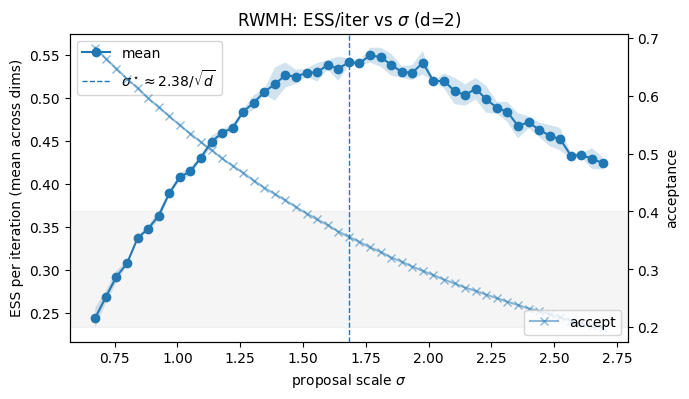

d=2: empirical best σ = 1.7671, theory σ* ≈ 1.6829, accept@best ≈ 0.338


,scale,ess_iter,accept
0,0.3010,0.0566,0.6460
1,0.3199,0.0612,0.6255
2,0.3387,0.0671,0.6047
3,0.3575,0.0710,0.5856
4,0.3763,0.0770,0.5658
5,0.3951,0.0802,0.5475
6,0.4139,0.0847,0.5285
7,0.4328,0.0891,0.5102
8,0.4516,0.0940,0.4916
9,0.4704,0.0967,0.4748


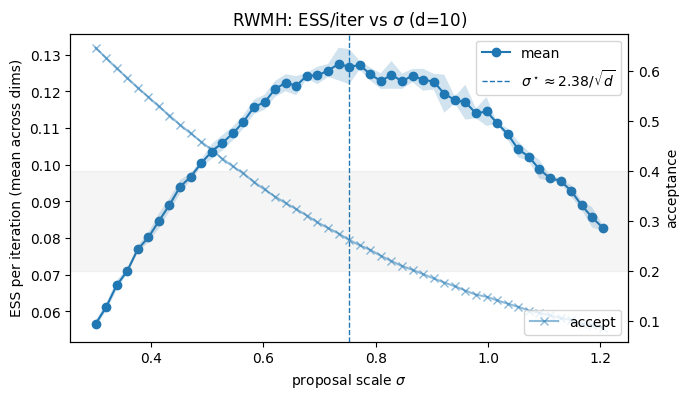

d=10: empirical best σ = 0.7338, theory σ* ≈ 0.7526, accept@best ≈ 0.274


In [20]:
def sigma_grid_for_d(d, width_pct=0.6, n=49):
    sig_star = 2.38 / np.sqrt(d)
    lo, hi = sig_star*(1-width_pct), sig_star*(1+width_pct)
    return np.linspace(lo, hi, n)

for d in [2, 10]:
    scales = sigma_grid_for_d(d, width_pct=0.6, n=49)
    df = sweep_rwmh_essiter_vs_sigma(
        d=d, scales=scales, n_chains=4, burn_in=2000, num_samples=20000, seeds=3
    )
    display(df[["scale","ess_iter","accept"]].style.format(precision=4)
            .set_caption(f"RWMH ESS/iter vs σ (d={d})"))
    plot_essiter_vs_sigma(df, d)

    # empirical maximizer vs theory
    i = int(df["ess_iter"].argmax())
    sig_emp = df.loc[i, "scale"]
    sig_the = 2.38 / np.sqrt(d)
    print(f"d={d}: empirical best σ = {sig_emp:.4f}, theory σ* ≈ {sig_the:.4f}, "
          f"accept@best ≈ {df.loc[i,'accept']:.3f}")

In [ ]:
def ess_per_iter_mean(samples_tcd: np.ndarray) -> float:
    """Mean bulk ESS per iteration across dimensions."""
    T, C, _ = samples_tcd.shape
    idata = to_inferencedata(samples_tcd)
    ess = az.summary(idata, var_names=["x"], round_to=None)["ess_bulk"].to_numpy()
    total_draws = max(T * C, 1)
    return float(np.mean(ess) / total_draws)


def sweep_hmc_dense(
    d: int,
    eps_grid,
    L_grid,
    n_chains: int = 4,
    burn_in: int = 1000,
    num_samples: int = 4000,
    seeds: int = 3,
) -> pd.DataFrame:
    rows = []
    init = jnp.zeros((n_chains, d), dtype=jnp.float32)

    # # tiny warm-up (compile) – excluded from measurements
    # key_warm = random.PRNGKey(123456 + d)
    # _ = hmc_run(key_warm, standard_normal_log_prob, init, 0.05, 10, 50, burn_in=50)

    for L in L_grid:
        for eps in eps_grid:
            essi, accs = [], []
            for s in range(seeds):
                key = random.PRNGKey(9000 + 100*d + 10*L + s)
                out = hmc_run(
                    key,
                    standard_normal_log_prob,
                    init,
                    float(eps),
                    int(L),
                    num_samples,
                    burn_in=burn_in,
                )
                samples, _, accept_rate, _ = unpack_run_output(out, num_samples)
                if accept_rate is not None:
                    accept_rate = np.asarray(accept_rate, dtype=float)
                essi.append(ess_per_iter_mean(samples))
                accs.append(float(np.mean(accept_rate)) if accept_rate is not None else np.nan)
            ess_iter = float(np.mean(essi))
            rows.append({
                "d": d,
                "eps": float(eps),
                "L": int(L),
                "ess_per_iter": ess_iter,
                "ess_per_grad": ess_iter / max(int(L), 1),
                "accept": float(np.nanmean(accs)),
            })
    df = pd.DataFrame(rows)

    return df


def plot_heatmap_ess_grad(df: pd.DataFrame, d: int):
    """Heatmap of ESS/grad over (eps, L) with argmax marker and annotation."""
    pt = df.pivot(index="L", columns="eps", values="ess_per_grad")
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    hm = sns.heatmap(pt, cmap="viridis", ax=ax)
    ax.set_title(f"HMC (d={d}): ESS per gradient over (ε, L)")
    ax.set_xlabel("ε")
    ax.set_ylabel("L")

    # Find and mark the global argmax
    best_idx = df["ess_per_grad"].argmax()
    best_row = df.iloc[best_idx]

    xcol = np.where(pt.columns.values == best_row["eps"])[0][0] + 0.5  # center the marker
    yrow = np.where(pt.index.values   == best_row["L"]  )[0][0] + 0.5
    ax.scatter(xcol, yrow, marker="*", s=220, c="w", edgecolors="k", linewidths=0.8, zorder=5)

    # digit limit
    ax.set_xticklabels([f"{x:.2f}" for x in pt.columns.values], rotation=45, ha="right")

    ax.text(
        0.88, 0.02,
        (
            f"best:\n"
            f"  ε* = {best_row['eps']:.3f}\n"
            f"  L* = {int(best_row['L'])}\n"
            f"  τ* = {best_row['eps']*best_row['L']:.3f}\n"
            f"  d^¼ ε* = {(d**0.25)*best_row['eps']:.3f}\n"
            f"  accept@* = {best_row['accept']:.3f}\n"
            f"  ESS/grad = {best_row['ess_per_grad']:.4g}"
        ),
        transform=ax.transAxes, va="bottom", ha="left", fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.85)
    )

    plt.tight_layout()
    plt.show()


def plot_fixed_tau_slice(df: pd.DataFrame, d: int, tau: float, tol: float = 1e-3):
    """
    Plot ESS/grad vs ε along a fixed-τ slice (select rows where |L*ε - τ| <= tol).
    Overlays acceptance on a secondary axis; marks argmax and 0.651 reference.
    """
    # Build slice
    sl = df.loc[np.abs(df["L"] * df["eps"] - tau) <= tol].copy()
    if sl.empty:
        # If no exact matches, pick the closest row per ε by rounding
        rows = []
        for eps in sorted(df["eps"].unique()):
            L_target = int(np.round(tau / eps))
            if L_target <= 0:
                continue
            cand = df[(df["eps"] == eps) & (df["L"] == L_target)]
            if not cand.empty:
                rows.append(cand.iloc[0])
        if rows:
            sl = pd.DataFrame(rows)


    sl = sl.sort_values("eps").reset_index(drop=True)

    # argmax on the slice
    best_idx = sl["ess_per_grad"].argmax()
    best_row = sl.iloc[best_idx]

    fig, ax1 = plt.subplots(1, 1, figsize=(9, 4.5))
    ax1.plot(sl["eps"], sl["ess_per_grad"], marker="o", lw=1.5, label="ESS/grad")
    ax1.axvline(best_row["eps"], ls="--", lw=1.0, color="k", alpha=0.6)
    ax1.set_xlabel("ε")
    ax1.set_ylabel("ESS per gradient")
    ax1.set_title(f"HMC (d={d}, fixed τ≈{tau}) : ESS/grad vs ε")

    ax2 = ax1.twinx()
    ax2.plot(sl["eps"], sl["accept"], marker="x", ls="-.", alpha=0.7, color="tab:gray", label="accept")
    ax2.axhline(0.651, ls="--", lw=1.0, color="tab:red", alpha=0.8)
    ax2.set_ylabel("acceptance")

    ax1.text(
        0.02, 0.02,
        (
            f"argmax on slice:\n"
            f"  ε* = {best_row['eps']:.4f}\n"
            f"  L* = {int(best_row['L'])}\n"
            f"  τ* = {best_row['eps']*best_row['L']:.4f}\n"
            f"  accept@* = {best_row['accept']:.3f}\n"
            f"  d^¼ ε* = {(d**0.25)*best_row['eps']:.4f}"
        ),
        transform=ax1.transAxes, va="bottom", ha="left", fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.85)
    )

    lines1, labs1 = ax1.get_legend_handles_labels()
    lines2, labs2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labs1 + labs2, loc="upper right", fontsize=8)

    plt.tight_layout()
    plt.show()

/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered i

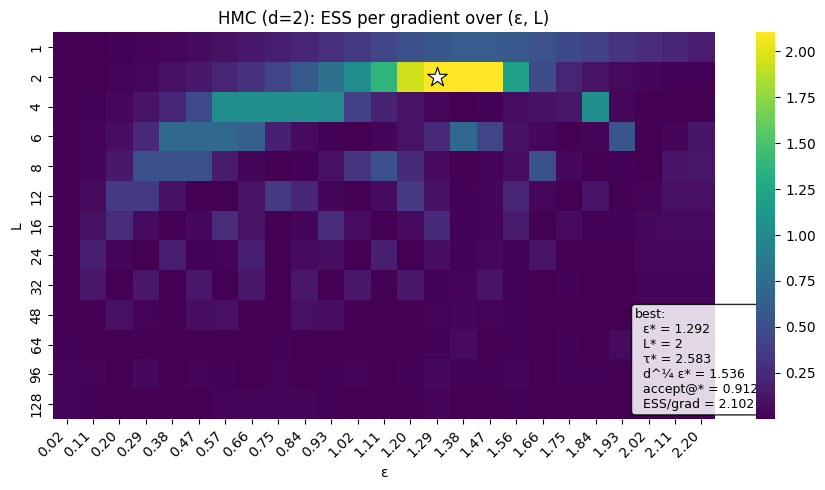

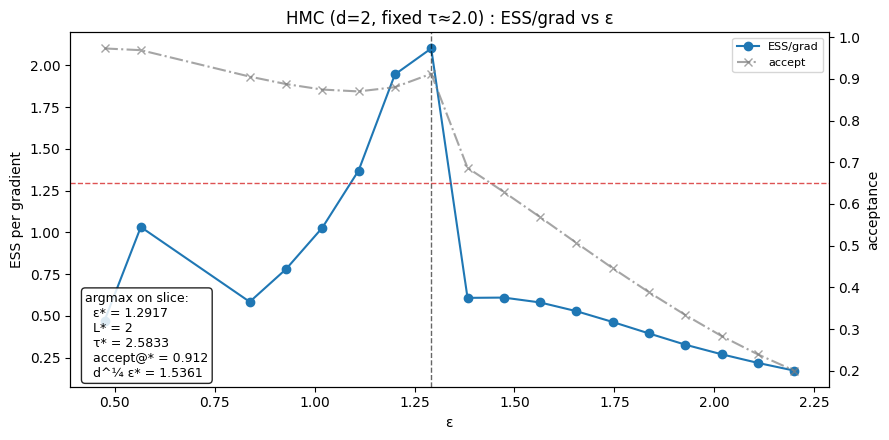

,eps,L,ess_per_grad,ess_per_iter,accept
39,1.2917,2,2.1021,4.2041,0.9120
40,1.3825,2,2.1021,4.2041,0.9710
41,1.4733,2,2.1021,4.2041,0.9318
38,1.2008,2,1.9465,3.8930,0.8799
37,1.1100,2,1.3708,2.7416,0.8697
42,1.5642,2,1.2055,2.4110,0.7911
57,0.6558,4,1.0510,4.2041,0.9742
58,0.7467,4,1.0510,4.2041,0.9938
59,0.8375,4,1.0510,4.2041,0.9702
70,1.8367,4,1.0507,4.2027,0.8799


,eps,L,ess_per_grad,ess_per_iter,accept
39,1.2917,2.0000,2.1021,4.2041,0.9120


/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered i

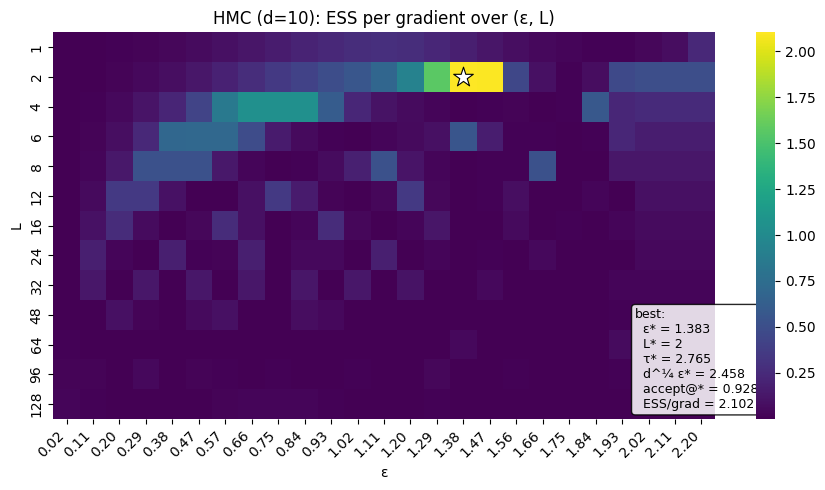

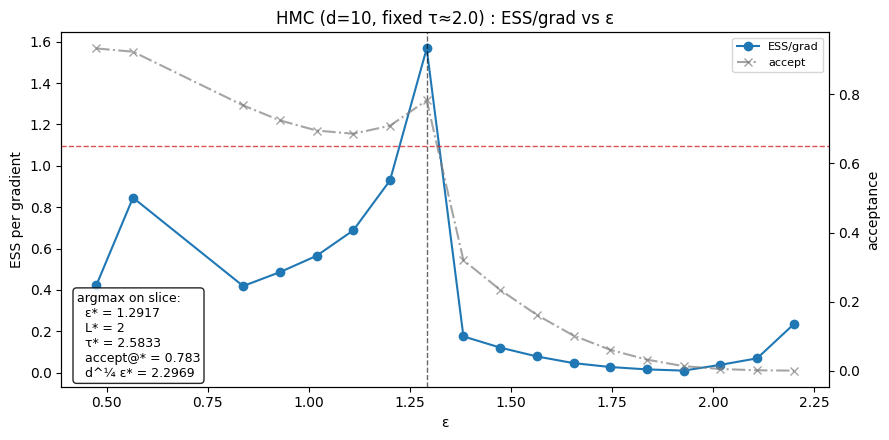

,eps,L,ess_per_grad,ess_per_iter,accept
40,1.3825,2,2.1021,4.2041,0.9280
41,1.4733,2,2.0873,4.1746,0.8336
39,1.2917,2,1.5678,3.1356,0.7827
59,0.8375,4,1.0510,4.2041,0.9264
58,0.7467,4,1.0510,4.2041,0.9852
57,0.6558,4,1.0510,4.2041,0.9368
38,1.2008,2,0.9293,1.8585,0.7092
56,0.5650,4,0.8459,3.3835,0.9235
80,0.4742,6,0.7007,4.2041,0.9812
81,0.5650,6,0.7007,4.2041,0.9708


,eps,L,ess_per_grad,ess_per_iter,accept
40,1.3825,2.0000,2.1021,4.2041,0.9280


/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered i

In [ ]:
eps_grid_d2  = np.linspace(0.02, 2.2, 25)   # d=2
eps_grid_d10 = np.linspace(0.02, 2.2, 25)   # d=10
eps_grid_d50 = np.linspace(0.02, 2.2, 25)   # d=100

L_grid = np.array([1, 2, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128], dtype=int)

settings = dict(n_chains=4, burn_in=1000, num_samples=4000, seeds=30)

for d, eps_grid in [(2, eps_grid_d2), (10, eps_grid_d10), (100, eps_grid_d50)]:
    df = sweep_hmc_dense(d, eps_grid, L_grid, **settings)

    plot_heatmap_ess_grad(df, d)
    plot_fixed_tau_slice(df, d, tau=2.0, tol=5e-3)

    top = (df.sort_values("ess_per_grad", ascending=False)
             .head(12)[["eps","L","ess_per_grad","ess_per_iter","accept"]])
    display(top.style.format(precision=4).set_caption(f"Top configs by ESS/grad (d={d})"))

    best = df.sort_values("ess_per_grad", ascending=False).iloc[0]
    display(pd.DataFrame([best])[["eps","L","ess_per_grad","ess_per_iter","accept"]]
        .style.format(precision=4)
        .set_caption(f"Best config by ESS/grad (d={d})"))
